In [229]:
import os, datetime
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
import torch
import scipy
import sklearn
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import scikit_posthocs as sp
import torchmetrics
import pytorch_lightning as L
from hnc_project import data_prep as dp
from hnc_project.pytorch.run_model_lightning import RunModel
from hnc_project.pytorch.user_metrics import MMetric

In [248]:
no_graph_log_dir = './logs/lightning_no_graph_feat64_true_weight3_balance_real_dp3_l21e6_11180_minmax_rot3_balance_newclinical_nolrfinder_nocensor_v54'
#graph_log_dir = './logs/lightning_graph_feat64_true_weight3_balance_real_dp3_l21e6_11180_minmax_rot3_balance_newclinical_nolrfinder_nocensor_v55'
graph_log_dir = './logs/lightning_undirected_edge_graph_feat64_true_weight3_balance_real_dp3_l21e6_11180_minmax_rot3_balance_newclinical_nolrfinder_nocensor_v56'
#graph_log_dir = './logs/lightning_reverse_edge_graph_feat64_true_weight3_balance_real_dp3_l21e6_11180_minmax_rot3_balance_newclinical_nolrfinder_nocensor_v56'
test_pred_file = 'metric_dfs/test_predictions.pkl'
val_pred_file = 'metric_dfs/val_predictions.pkl'
m_fn = MMetric(0.6, 0.4)

In [249]:
test_graph_pred = pd.read_pickle(os.path.join(graph_log_dir, test_pred_file))
test_no_graph_pred = pd.read_pickle(os.path.join(no_graph_log_dir, test_pred_file))
val_graph_pred = pd.read_pickle(os.path.join(graph_log_dir, val_pred_file))
val_no_graph_pred = pd.read_pickle(os.path.join(no_graph_log_dir, val_pred_file))


In [258]:
test_graph_avg = []
test_no_graph_avg = []
test_graph_m = []
test_no_graph_m = []

for idx in range(5):
    test_graph_avg.append(list(test_graph_pred['val_auc'][idx]))
    test_no_graph_avg.append(list(test_no_graph_pred['val_loss'][idx]))
    test_graph_m.append(m_fn(sen_fn(test_graph_pred['val_auc'][idx], test_graph_pred['targets'][idx]), spe_fn(test_graph_pred['val_loss'][idx], test_graph_pred['targets'][idx])))
    test_no_graph_m.append(m_fn(sen_fn(test_no_graph_pred['val_loss'][idx], test_no_graph_pred['targets'][idx]), spe_fn(test_no_graph_pred['val_loss'][idx], test_no_graph_pred['targets'][idx])))

test_graph_m = torch.tensor(test_graph_m)
test_no_graph_m = torch.tensor(test_no_graph_m)

test_graph_weight = test_graph_m / test_graph_m.sum()
test_no_graph_weight = test_no_graph_m / test_no_graph_m.sum()
test_graph_weight_update = []
test_no_graph_weight_update = []
for idx in range(5):
    test_graph_weight_update.append([test_graph_weight[idx]] * len(test_graph_pred['targets'][0]))
    test_no_graph_weight_update.append([test_no_graph_weight[idx]] * len(test_no_graph_pred['targets'][0]))


In [259]:
test_graph_avg = np.average(test_graph_avg, axis=0, weights=test_graph_weight_update)    
test_no_graph_avg = np.average(test_no_graph_avg, axis=0, weights=test_no_graph_weight_update)    

In [263]:
t, p = scipy.stats.ttest_rel(test_graph_avg, test_no_graph_avg)
print(p)

3.1010059605005368e-83


In [159]:
for idx in range(5):
    t1, p1 = scipy.stats.ttest_rel(val_graph_pred['val_auc'][idx], val_no_graph_pred['val_m'][idx])
    t2, p2 = scipy.stats.ttest_rel(test_graph_pred['val_auc'][idx], test_no_graph_pred['val_m'][idx])
    print(p1, p2)

4.084085512012148e-46 2.76911233228084e-82
1.1947688143735074e-08 6.161477342196688e-22
7.551037108869269e-70 5.771009330031221e-110
4.951022244685963e-28 5.484122080249205e-79
1.3298441829942379e-17 4.4076900306013466e-41


In [252]:
# all of the metrics used in the evaluation, can add or remove as desired
auc_fn = torchmetrics.classification.BinaryAUROC()
ap_fn = torchmetrics.classification.BinaryAveragePrecision()
spe_fn = torchmetrics.classification.BinarySpecificity()
sen_fn = torchmetrics.classification.BinaryRecall()

roc_fn = torchmetrics.classification.BinaryROC()
pr_fn = torchmetrics.classification.BinaryPrecisionRecallCurve()

In [253]:
# resets metric functions, should be run for each successive evaluation of probabilities as values entered into functions are persistent until reset
auc_fn.reset()
ap_fn.reset()
spe_fn.reset()
sen_fn.reset()
roc_fn.reset()
pr_fn.reset()

In [260]:
graph_auc = auc_fn(torch.tensor(test_graph_avg), test_graph_pred['targets'][0])
no_graph_auc = auc_fn(torch.tensor(test_no_graph_avg), test_no_graph_pred['targets'][0])
graph_ap = ap_fn(torch.tensor(test_graph_avg), test_graph_pred['targets'][0].to(torch.long))
no_graph_ap = ap_fn(torch.tensor(test_no_graph_avg), test_no_graph_pred['targets'][0].to(torch.long))
graph_sen = sen_fn(torch.tensor(test_graph_avg), test_graph_pred['targets'][0])
no_graph_sen = sen_fn(torch.tensor(test_no_graph_avg), test_no_graph_pred['targets'][0])
graph_spe = spe_fn(torch.tensor(test_graph_avg), test_graph_pred['targets'][0])
no_graph_spe = spe_fn(torch.tensor(test_no_graph_avg), test_no_graph_pred['targets'][0])
print('auc:', graph_auc, no_graph_auc)
print('ap:', graph_ap, no_graph_ap)
print('sen:', graph_sen, no_graph_sen)
print('spe:', graph_spe, no_graph_spe)

auc: tensor(0.7672) tensor(0.7680)
ap: tensor(0.3550) tensor(0.3819)
sen: tensor(0.7313) tensor(0.4627)
spe: tensor(0.6508) tensor(0.8753)


In [ ]:
auc_fn.reset()
auc_fn.update(torch.tensor(test_graph_avg), test_graph_pred['targets'][0])
graph_auc = auc_fn.compute()
auc_fn.reset()
auc_fn.update(torch.tensor(test_no_graph_avg), test_no_graph_pred['targets'][0])
no_graph_auc = auc_fn.compute()

ap_fn.reset()
ap_fn.update(torch.tensor(test_graph_avg), test_graph_pred['targets'][0].to(torch.long))
graph_ap = ap_fn.compute()
ap_fn.reset()
ap_fn.update(torch.tensor(test_no_graph_avg), test_no_graph_pred['targets'][0].to(torch.long))
no_graph_ap = ap_fn.compute()

sen_fn.reset()
sen_fn.update(torch.tensor(test_graph_avg), test_graph_pred['targets'][0])
graph_sen = sen_fn.compute()
sen_fn.reset()
sen_fn.update(torch.tensor(test_no_graph_avg), test_no_graph_pred['targets'][0])
no_graph_sen = sen_fn.compute()

spe_fn.reset()
spe_fn.update(torch.tensor(test_graph_avg), test_graph_pred['targets'][0])
graph_spe = spe_fn.compute()
spe_fn.reset()
spe_fn.update(torch.tensor(test_no_graph_avg), test_no_graph_pred['targets'][0])
no_graph_spe = spe_fn.compute()

print('auc:', graph_auc, no_graph_auc)
print('ap:', graph_ap, no_graph_ap)
print('sen:', graph_sen, no_graph_sen)
print('spe:', graph_spe, no_graph_spe)

In [261]:
graph_fold_aucs = []
no_graph_fold_aucs = []
for idx in range(5):
    graph_fold_aucs.append(auc_fn((test_graph_pred['val_auc'][idx]), test_graph_pred['targets'][0]))
    no_graph_fold_aucs.append(auc_fn((test_no_graph_pred['val_loss'][idx]), test_no_graph_pred['targets'][0]))

print((graph_fold_aucs))
print((no_graph_fold_aucs))

[tensor(0.7282), tensor(0.7635), tensor(0.7421), tensor(0.7791), tensor(0.7032)]
[tensor(0.7331), tensor(0.7498), tensor(0.7458), tensor(0.7918), tensor(0.7452)]


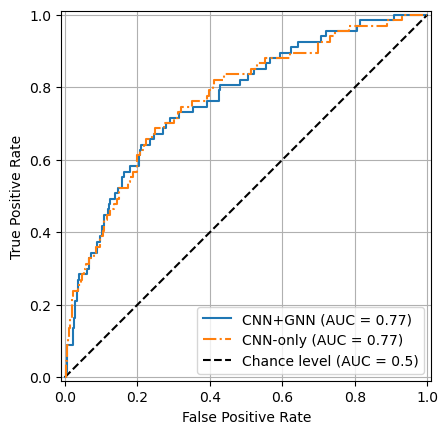

In [262]:
from sklearn.metrics import RocCurveDisplay
target = test_graph_pred['targets'][0]
#figure = plt.figure()
#axes = figure.add_subplot(111)
display = RocCurveDisplay.from_predictions(target, test_graph_avg, name='CNN+GNN', plot_chance_level=True)
RocCurveDisplay.from_predictions(target, test_no_graph_avg, name='CNN-only', plot_chance_level=False, ax=display.ax_)
plt.grid(visible=True, which='both')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
handles, labels = plt.gca().get_legend_handles_labels()
line_styles = ['-', '--', '-.', ':']
for line, ls in zip(display.ax_.get_lines(), line_styles):
    line.set_linestyle(ls)
plt.legend([handles[idx] for idx in [0, 2, 1]], [labels[idx] for idx in [0, 2, 1]])
display.figure_.savefig(f"roc_curve_GNN.pdf", dpi=600)
plt.show()

In [19]:
display.figure_.savefig(f"roc_curve_GNN.png", dpi=600)

In [82]:
len(test_graph_pred['targets'][4])

508

### Testing models

In [4]:
graph_log_dir = './logs/lightning_graph_feat64_weight9_balance_real_dp3_l21e6_11180_minmax_rot3_balance_newclinical_nolrfinder_nocensor_v50'
no_graph_log_dir = './logs/lightning_no_graph_feat64_weight7p5_balance_real_dp3_l21e6_11180_minmax_rot3_balance_newclinical_nolrfinder_nocensor_v52'
test_pred_file = 'metric_dfs/test_predictions.pkl'
gnn_config_file = os.path.join(graph_log_dir, 'csvlog_fold_0','lightning_logs','version_1','hparams.yaml')
cnn_config_file = os.path.join(no_graph_log_dir, 'csvlog_fold_0','lightning_logs','version_0','hparams.yaml')
graph_m_models = [
    'model_m_epoch=47_val_loss=1.33_val_auc=0.74_val_m=0.75.ckpt',
    'model_m_epoch=47_val_loss=1.24_val_auc=0.74_val_m=0.75.ckpt',
    'model_m_epoch=56_val_loss=1.41_val_auc=0.76_val_m=0.75.ckpt',
    'model_m_epoch=14_val_loss=1.23_val_auc=0.74_val_m=0.77.ckpt',
    'model_m_epoch=73_val_loss=1.46_val_auc=0.77_val_m=0.81.ckpt',
]
graph_loss_models = [
    'model_loss_epoch=04_val_loss=1.28_val_auc=0.70_val_m=0.62.ckpt',
    'model_loss_epoch=50_val_loss=1.12_val_auc=0.75_val_m=0.69.ckpt',
    'model_loss_epoch=58_val_loss=1.20_val_auc=0.78_val_m=0.60.ckpt',
    'model_loss_epoch=14_val_loss=1.23_val_auc=0.74_val_m=0.77.ckpt',
    'model_loss_epoch=58_val_loss=1.41_val_auc=0.75_val_m=0.72.ckpt',
]

In [117]:
gnn_config = yaml.safe_load(open(gnn_config_file, 'r'))
cnn_config = yaml.safe_load(open(cnn_config_file, 'r'))



In [124]:
gnn_model = RunModel(config=gnn_config['config'])
cnn_model = RunModel(config=cnn_config['config'])

#gnn_model.config['remove_censored'] = False
#cnn_model.config['remove_censored'] = False

Seed set to 42
Seed set to 42


logs are located at: logs/lightning_graph_feat64_weight9_balance_real_dp3_l21e6_11180_minmax_rot3_balance_newclinical_nolrfinder_nocensor_v50
logs are located at: logs/lightning_no_graph_feat64_weight7p5_balance_real_dp3_l21e6_11180_minmax_rot3_balance_newclinical_nolrfinder_nocensor_v52


In [123]:
gnn_model.config['remove_censored'] = False
gnn_model.config['remove_censored']

False

In [ ]:
gnn_model.set_model()
gnn_model.set_data()
gnn_model.set_train_test_split_challenge()
gnn_model.set_data_module()
gnn_model.set_callbacks(5)
idx = 5
gnn_model.trainer = L.Trainer(
                max_epochs=gnn_model.config['n_epochs'],
                accelerator="auto",
                devices=gnn_model.config['gpu_device'] if torch.cuda.is_available() else None,
                logger=[L.loggers.CSVLogger(save_dir=os.path.join(gnn_model.log_dir, f"csvlog_fold_{idx}")), L.loggers.TensorBoardLogger(save_dir=os.path.join(gnn_model.log_dir, f"tb_fold_{idx}"))],
                callbacks=gnn_model.callbacks,
                #check_val_every_n_epoch = 1,
                #auto_lr_find=True
)

In [120]:
cnn_model.set_model()
cnn_model.set_data()
cnn_model.set_train_test_split_challenge()
cnn_model.set_data_module()
cnn_model.set_callbacks(5)
idx = 5
cnn_model.trainer = L.Trainer(
                max_epochs=cnn_model.config['n_epochs'],
                accelerator="auto",
                devices=cnn_model.config['gpu_device'] if torch.cuda.is_available() else None,
                logger=[L.loggers.CSVLogger(save_dir=os.path.join(cnn_model.log_dir, f"csvlog_fold_{idx}")), L.loggers.TensorBoardLogger(save_dir=os.path.join(cnn_model.log_dir, f"tb_fold_{idx}"))],
                callbacks=cnn_model.callbacks,
                #check_val_every_n_epoch = 1,
                #auto_lr_find=True
)

/home/s220127/miniconda3/envs/pytorch_gpu_v2/lib/python3.9/site-packages/torch_geometric/data/lightning/datamodule.py:43: The 'shuffle=True' option is ignored in 'LightningDataset'. Remove it from the argument list to disable this warning
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [121]:
model_idx = 0
gnn_model.trainer.test(gnn_model.model,
                       datamodule=gnn_model.data_module_cross_val[model_idx], 
                       ckpt_path=os.path.join(graph_log_dir, 
                                              f"top_models_fold_{model_idx}", 
                                              graph_loss_models[model_idx])
                      )

Restoring states from the checkpoint path at ./logs/lightning_graph_feat64_weight9_balance_real_dp3_l21e6_11180_minmax_rot3_balance_newclinical_nolrfinder_nocensor_v50/top_models_fold_0/model_loss_epoch=04_val_loss=1.28_val_auc=0.70_val_m=0.62.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at ./logs/lightning_graph_feat64_weight9_balance_real_dp3_l21e6_11180_minmax_rot3_balance_newclinical_nolrfinder_nocensor_v50/top_models_fold_0/model_loss_epoch=04_val_loss=1.28_val_auc=0.70_val_m=0.62.ckpt


Testing: |                                                                                                    …

/home/s220127/miniconda3/envs/pytorch_gpu_v2/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/s220127/miniconda3/envs/pytorch_gpu_v2/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_ap            0.3880026042461395
        test_auc             0.768842875957489
         test_m             0.7498974800109863
        test_sen            0.7910447716712952
        test_spe            0.5963718891143799
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_auc': 0.768842875957489,
  'test_ap': 0.3880026042461395,
  'test_m': 0.7498974800109863,
  'test_sen': 0.7910447716712952,
  'test_spe': 0.5963718891143799}]

In [ ]:
model_idx = 0
cnn_model.trainer.test(cnn_model.model,
                       datamodule=cnn_model.data_module_cross_val[model_idx], 
                       ckpt_path=os.path.join(graph_log_dir, 
                                              f"top_models_fold_{model_idx}", 
                                              graph_loss_models[model_idx])
                      )

In [16]:
model_idx = 0
test_pred = gnn_model.trainer.predict(gnn_model.model,
                       gnn_model.data_module_cross_val[model_idx].test_dataloader(), 
                       ckpt_path=os.path.join(graph_log_dir, 
                                              f"top_models_fold_{model_idx}", 
                                              graph_loss_models[model_idx])
                      )

Restoring states from the checkpoint path at ./logs/lightning_graph_feat64_weight9_balance_real_dp3_l21e6_11180_minmax_rot3_balance_newclinical_nolrfinder_nocensor_v50/top_models_fold_0/model_loss_epoch=04_val_loss=1.28_val_auc=0.70_val_m=0.62.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at ./logs/lightning_graph_feat64_weight9_balance_real_dp3_l21e6_11180_minmax_rot3_balance_newclinical_nolrfinder_nocensor_v50/top_models_fold_0/model_loss_epoch=04_val_loss=1.28_val_auc=0.70_val_m=0.62.ckpt


Predicting: |                                                                                                 …

In [16]:
model_idx = 0
test_pred = cnn_model.trainer.predict(cnn_model.model,
                       cnn_model.data_module_cross_val[model_idx].test_dataloader(), 
                       ckpt_path=os.path.join(graph_log_dir, 
                                              f"top_models_fold_{model_idx}", 
                                              graph_loss_models[model_idx])
                      )

Restoring states from the checkpoint path at ./logs/lightning_graph_feat64_weight9_balance_real_dp3_l21e6_11180_minmax_rot3_balance_newclinical_nolrfinder_nocensor_v50/top_models_fold_0/model_loss_epoch=04_val_loss=1.28_val_auc=0.70_val_m=0.62.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at ./logs/lightning_graph_feat64_weight9_balance_real_dp3_l21e6_11180_minmax_rot3_balance_newclinical_nolrfinder_nocensor_v50/top_models_fold_0/model_loss_epoch=04_val_loss=1.28_val_auc=0.70_val_m=0.62.ckpt


Predicting: |                                                                                                 …

In [17]:
tmp_gnn_test_targets = []
for batch in gnn_model.data_module_cross_val[model_idx].test_dataloader():
    tmp_test_targets.append(batch.y)

In [105]:
auc_fn.update(torch.cat(gnn_model.model.test_preds).to('cpu'), torch.cat(gnn_model.model.test_targets).to('cpu'))
auc_fn.compute()

tensor(0.7617)

In [85]:
auc_fn.reset()
for idx in range(len(tmp_test_targets)):
    auc_fn.update(test_pred[idx], tmp_test_targets[idx])

auc_fn.compute()

tensor(0.7688)

In [110]:
auc_fn.reset()
auc_fn.update(torch.cat(test_pred), torch.cat(tmp_test_targets))
auc_fn.compute()

tensor(0.7705)

In [111]:
auc_fn.reset()
auc_fn(torch.cat(test_pred), torch.cat(tmp_test_targets))

tensor(0.7705)

In [11]:
gnn_model.model.test_targets

[tensor([0., 0.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([1., 0.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([1., 0.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([1., 0.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([1., 0.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([1., 0.], device='cuda:0'),
 tensor([0., 1.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([1., 0.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([1., 1.], device='cuda:0'),
 tensor([0., 0.], device='cu

In [15]:
torch.cat(test_pred) == torch.cat(gnn_model.model.test_preds).to('cpu')

tensor([ True,  True,  True,  True,  True, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True, False,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True, 

In [14]:
sklearn.metrics.roc_auc_score(torch.cat(tmp_test_targets), torch.cat(test_pred))

0.7551020408163265